# DESPLIEGUE DEL MODELO POKEMON TCG EN STREAMLIT

In [ ]:
import streamlit as st
from openai import OpenAI
import json
import requests

In [ ]:
# Claves de API
OPENAI_API_KEY =
POKEMON_TCG_API_KEY = "12bf9d80-fc20-494b-8445-a1360e7ce3c8"

client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def streamlit_main():

    # Imagen de los Pokémon decorativa
    st.image("https://wallpapers.com/images/hd/classic-pokemon-starter-characters-ufh3hzl8h80sd68a.jpg", width=800)

    # Título
    st.title("Pokémon TCG Wizard")

    # Texto adicional
    st.write("Ask the wizard about any Pokémon TCG card that has ever existed...")

    # Personalización de colores, bordes, sombras, etc.
    st.markdown(
        """
        <style>
        .stApp {
            background-color: #85C1E9;  /* Cambia el color de fondo de la página */
        }
        .stButton > button {
            background-color: #1B4F72;  /* Cambia el color del fondo del botón */
            color: white;  /* Cambia el color del texto del botón */
            border: 2px solid #1B4F72;  /* Borde alrededor del botón */
            box-shadow: 4px 4px 10px rgba(0, 0, 0, 0.3);  /* Sombra en el botón */
        }
        .stTextInput input {
            background-color: white;  /* Fondo del campo de texto */
            color: #1B4F72;  /* Color del texto */
            font-size: 20px;  /* Tamaño del texto */
            padding: 10px;  /* Espaciado dentro del campo */
        }

        </style>
        """,
        unsafe_allow_html=True
    )

    # Entrada del usuario
    question = st.text_input("Catch them all!")

    if st.button("Search"):
        st.write("You catched one!")
        if question:

            prompt_template = """
            **DON'T MAKE UP INFORMATION**. Extract specific details **ONLY** from the user's question and return a valid JSON dictionary.

            ### **Examples**:

            1. User: Who designed the neo genesis lugia and how much is it in dollars?
            Solution: {{"name":"lugia", "set.name":"neo genesis"}}

            2. User: What is the price of the umbreon vmax from evolving skies?
            Solution: {{"name":"umbreon", "subtypes":"vmax", "set.name":"evolving skies"}}

            3. User: when was released the charizard 199? can you show me a photo?
            Solution: {{"name":"charizard", "number":"199"}}

            4. User: when was released team rocket returns?
            Solution: {{"set.name":"team rocket returns"}}

            ### New user Input:
            {question}

            ### Your solution:
            """

            prompt = prompt_template.format(question=question)
            messages = [{"role": "user", "content": prompt}]

            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=messages,
                temperature=0,
            )

            try:
                str_dict = response.choices[0].message.content.strip()
                json_dict = json.loads(str_dict)
            except json.JSONDecodeError:
                st.error(f"Error: OpenAI returned an invalid JSON response.\nResponse: {str_dict}")
                return

            # Convertir JSON al formato de consulta de la API
            formatted_parts = [f'{key}:"{value}"' for key, value in json_dict.items()]
            query = " ".join(formatted_parts)

            # Llamar a la API de Pokémon TCG
            url = "https://api.pokemontcg.io/v2/cards"
            headers = {"X-Api-Key": POKEMON_TCG_API_KEY}
            params = {"q": query}

            response = requests.get(url, params=params, headers=headers)

            if response.status_code == 200:
                card_data = response.json()
            else:
                st.error(f"API Error: {response.status_code}")
                return

            if not isinstance(card_data, dict) or 'data' not in card_data or not card_data['data']:
                st.error("API Error: No data found or incorrect response format.")
                st.write("Response from API:", card_data)
                return

            # Formatear el contexto para OpenAI
            context = ""
            for i, card in enumerate(card_data['data'], start=1):
                card_info = (
                    f"Card {i}:\n"
                    f"Name: {card.get('name', 'N/A')}\n"
                    f"Subtypes: {', '.join(card.get('subtypes', []))}\n"
                    f"Number: {card.get('number', 'N/A')}\n"
                    f"Artist: {card.get('artist', 'N/A')}\n"
                    f"Set Name: {card.get('set', {}).get('name', 'N/A')}\n"
                    f"Set Series: {card.get('set', {}).get('series', 'N/A')}\n"
                    f"Release Date: {card.get('set', {}).get('releaseDate', 'N/A')}\n"
                    f"Large Image: {card.get('images', {}).get('large', 'N/A')}\n"
                    f"Market Price TCGPlayer: ${card.get('tcgplayer', {}).get('prices', {}).get('holofoil', {}).get('market', 'N/A')}\n"
                    f"TCGPlayer URL: {card.get('tcgplayer', {}).get('url', 'N/A')}\n"
                    f"Market Price Cardmarket: {card.get('cardmarket', {}).get('prices', {}).get('avg7', 'N/A')}€\n"
                    f"Cardmarket URL: {card.get('cardmarket', {}).get('url', 'N/A')}\n\n"
                )

                # Limitar la longitud del contexto
                if len(context) > 4000:
                    context = context[:3000] + "...\n[Context trimmed due to token limit]"
                    break

                context += card_info

            # Generar una respuesta con OpenAI usando RAG
            prompt_template = """
            You are a Pokémon TCG expert. You must answer the given question and extract the information ONLY from the given context. If you cannot answer the question with the context, please respond with 'I don't know'.

            ### Context:
            {context}

            ### Question:
            {question}

            ### Answer:
            """
            prompt = prompt_template.format(question=question, context=context)
            messages = [{"role": "user", "content": prompt}]

            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=messages,
                temperature=0,
            )
            answer = response.choices[0].message.content

            # Mostrar la salida
            st.write(answer)

            # Mostrar la imagen si se solicita
            words = answer.split()
            for word in words:
                if word.startswith("http") and (".jpg" in word or ".png" in word):
                    st.image(word, caption="Card Image", use_container_width=True)
                    break

        else:
            st.warning("Please enter a valid query.")

if __name__ == "__main__":
    streamlit_main()

2025-02-02 17:10:32.200 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-02 17:10:32.205 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-02 17:10:32.346 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-02 17:10:32.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-02 17:10:32.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-02 17:10:32.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-02 17:10:32.358 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

## INTERFAZ Y FUNCIONAMIENTO DEL MODELO

* INTERFAZ DEL MODELO

In [ ]:
from PIL import Image
from IPython.display import display

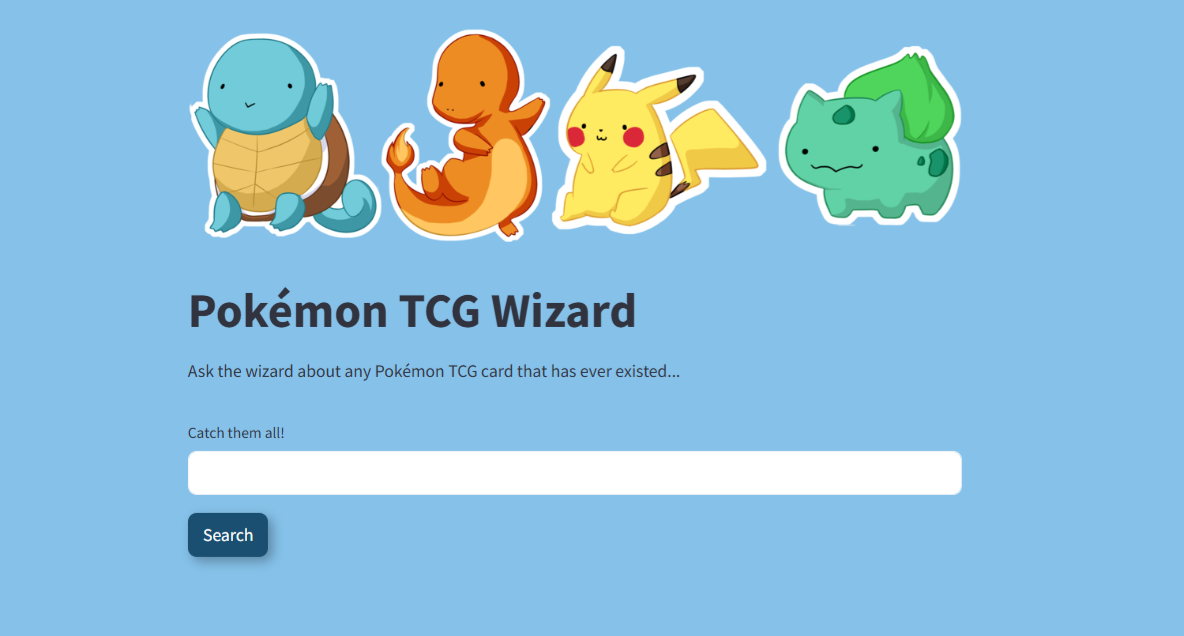

In [ ]:
image1 = Image.open("/content/foto_1.png")
display(image1)

* EJEMPLO 1:

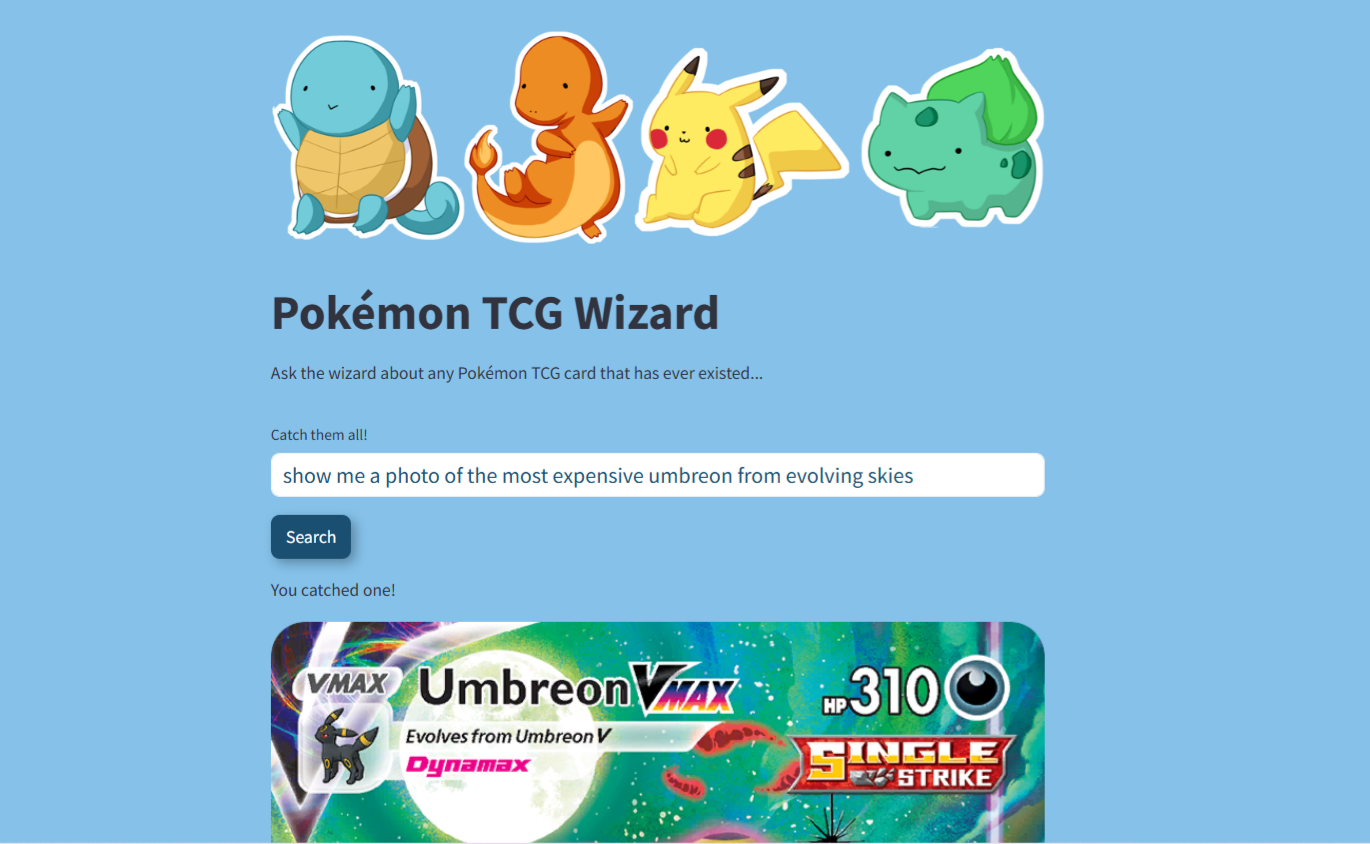

In [ ]:
image2 = Image.open("/content/foto_2.png")
display(image2)

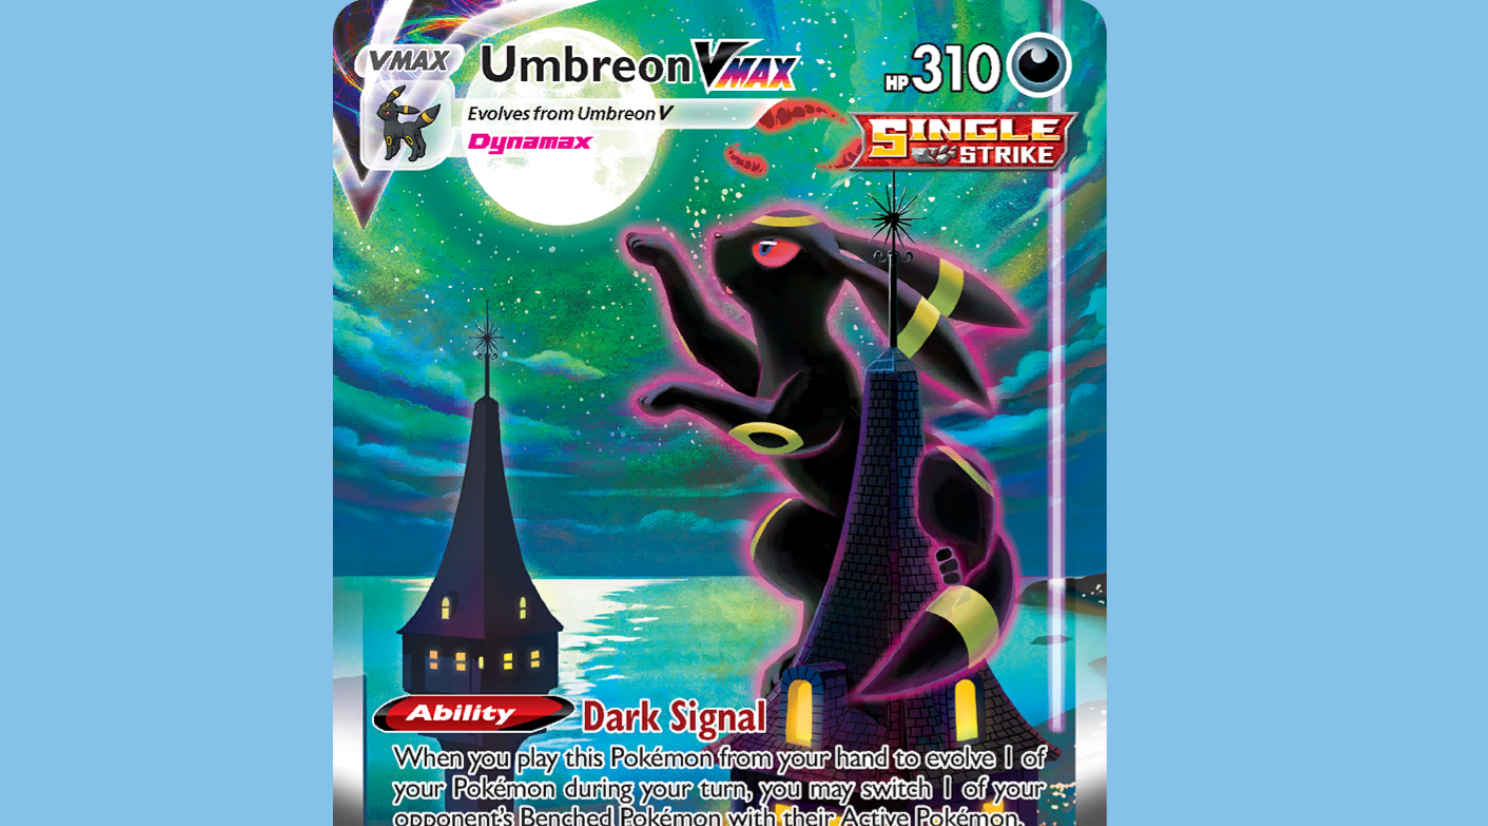

In [ ]:
image3 = Image.open("/content/foto_3.png")
display(image3)

* EJEMPLO 2:

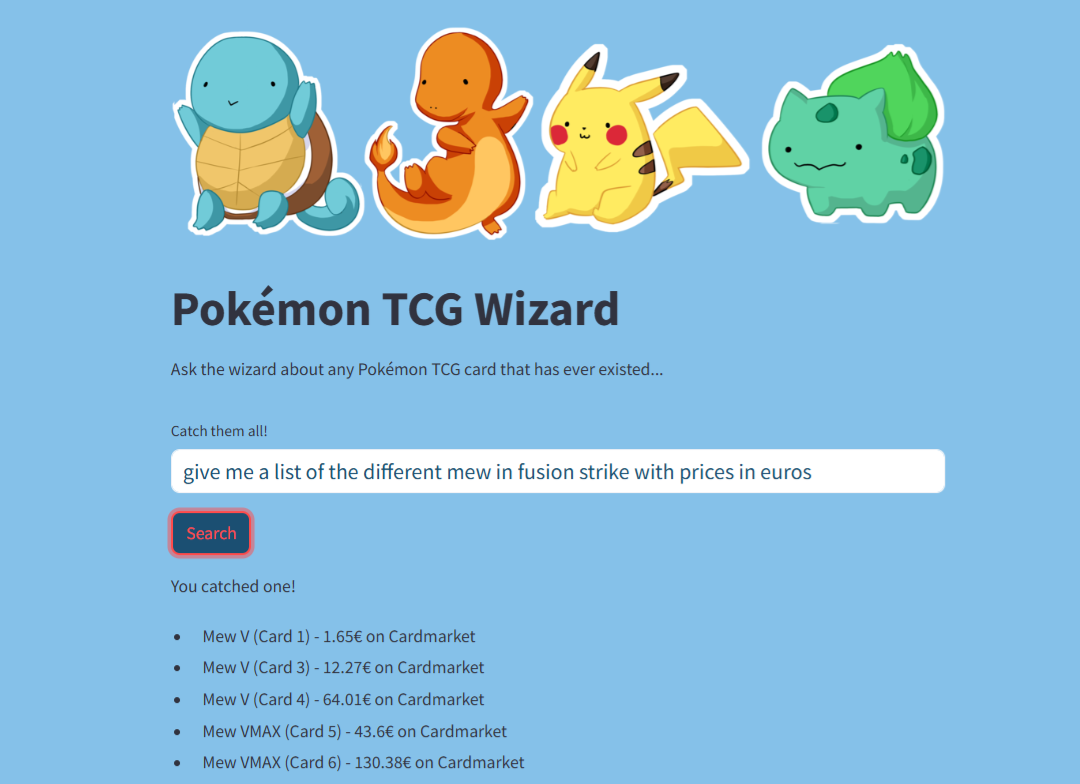

In [ ]:
image4 = Image.open("/content/foto_4.png")
display(image4)

* EJEMPLO 3:

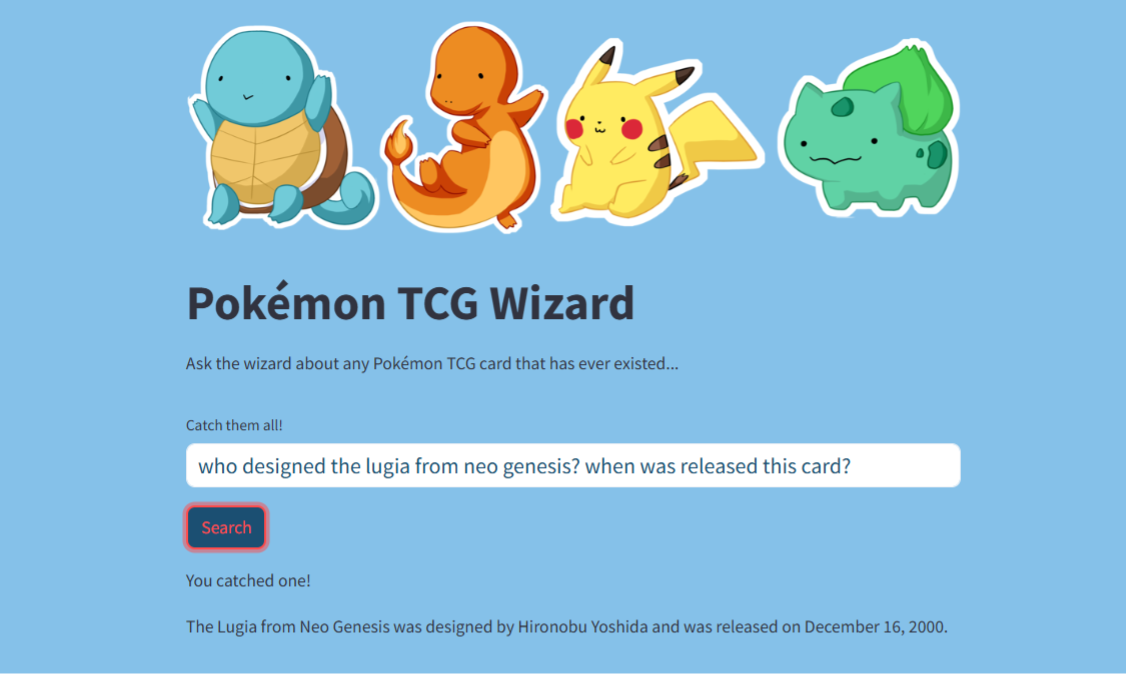

In [ ]:
image5 = Image.open("/content/foto_5.png")
display(image5)